<a href="https://colab.research.google.com/github/Wissg/Trading-code/blob/main/trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader[plotting]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 9.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime 
from datetime import date
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt

#test 1 


In [ ]:
def trading_strategy(ticker, start_date, end_date, time_frame='1D', sma_short=3, sma_long=7,
                     buy_threshold=0.05, sell_threshold=-0.05, daily_investment=100, stop_loss=0.001,
                     take_profit=0.001, initial_cash=10000, commission=0.01):
    
    stock_data = yf.download(ticker, start_date, end_date)

    # Resample the data to the desired time frame
    resampled_data = stock_data.resample(time_frame).last()

    #remove nan value (dayoff)
    resampled_data.dropna(inplace=True)
    
    # Compute the moving averages
    resampled_data[f'SMA{str(sma_short)}'] = resampled_data['Close'].rolling(window=sma_short).mean()
    resampled_data[f'SMA{str(sma_long)}'] = resampled_data['Close'].rolling(window=sma_long).mean()
    
    # Determine the buy and sell signals
    signals = pd.DataFrame(index=resampled_data.index)
    signals['signal'] = 0.0
    signals[f'SMA{str(sma_short)}'] = resampled_data[f'SMA{str(sma_short)}']
    signals[f'SMA{str(sma_long)}'] = resampled_data[f'SMA{str(sma_long)}']
    signals['signal'][sma_long:] = np.where(
        signals[f'SMA{str(sma_short)}'][sma_long:] > signals[f'SMA{str(sma_long)}'][sma_long:] * (1 + buy_threshold),
        1.0, 0.0)
    signals['positions'] = signals['signal'].diff()

    # Compute the portfolio allocation and cash balance
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['price'] = resampled_data['Close']
    portfolio['positions'] = 0
    portfolio['cash'] = initial_cash
    portfolio['holdings'] = portfolio['positions'] * portfolio['price']
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    
    # Execute the trades
    for i in range(1, len(signals)):
        # Si le signal est différent de 0, on exécute un trade
        if signals['signal'][i] != 0:
            # Calcul de la quantité à acheter ou à vendre
            portfolio['positions'][i] = signals['signal'][i] * daily_cash / portfolio['holdings']
            
            # Calcul du prix d'achat ou de vente 
            price = portfolio['price'][i]
            
            # Si on achète (signal = 1)
            if signals['signal'][i] == 1:
                portfolio[i, 0] = portfolio[i-1, 0] - commission * np.abs(position_change) * price
                portfolio['cash'][i, 1] = portfolio['cash'][i-1, 1] + position_change
            # Si on vend (signal = -1)
            elif signals['signal'][i] == -1:
                # Si le prix descend en-dessous du stop loss, on ne fait rien
                if price <= stop_loss_level:
                    portfolio[i, :] = portfolio[i-1, :]
                # Si le prix dépasse le take profit, on achète tout
                elif price >= take_profit_level:
                    portfolio[i, 0] = portfolio[i-1, 0] + portfolio['cash'][i-1, 1] * take_profit_level - commission * np.abs(position_change) * price
                    portfolio[i, 1] = 0
                # Sinon, on vend
                else:
                    portfolio[i, 0] = portfolio[i-1, 0] - commission * np.abs(position_change) * price
                    portfolio['cash'][i, 1] = portfolio['cash'][i-1, 1] + position_change
            
       


    portfolio['holdings'] = portfolio['positions'] * portfolio['price']
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    # Plot the results
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211, ylabel=f'{ticker} price in $')
    resampled_data['Close'].plot(ax=ax1, color='black', lw=2.)
    resampled_data[f'SMA{str(sma_short)}'].plot(ax=ax1, color='red', lw=2.)
    resampled_data[f'SMA{str(sma_long)}'].plot(ax=ax1, color='blue', lw=2.)
    ax1.plot(signals.loc[signals.positions == 1.0].index, resampled_data[f'SMA{str(sma_short)}'][signals.positions == 1.0],
             '^', markersize=10, color='green', label='buy')
    ax1.plot(signals.loc[signals.positions == -1.0].index, resampled_data[f'SMA{str(sma_short)}'][signals.positions == -1.0],
             'v', markersize=10, color='red', label='sell')
    ax1.legend()
    ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
    portfolio['total'].plot(ax=ax2, lw=2.)
    ax2.plot(portfolio.loc[signals.positions == 1.0].index, portfolio['total'][signals.positions == 1.0],
             '^', markersize=10, color='green', label='buy')
    ax2.plot(portfolio.loc[signals.positions == -1.0].index, portfolio['total'][signals.positions == -1.0],
             'v', markersize=10, color='red', label='sell')
    ax2.plot(portfolio.loc[signals.positions == 0.0].index, portfolio['total'][signals.positions == 0.0],
             '.', markersize=10, color='black')
    ax2.legend()
    plt.show()
    
    # Print the final portfolio value and return
    final_value = portfolio['total'][-1]
    total_return = (final_value - initial_cash) / initial_cash
    print(f'Total portfolio value at the end of the period: {final_value:.2f} $')
    print(f'Total return over the period: {total_return:.2%}')


In [ ]:
strategy = trading_strategy('AAPL', '2020-02-25','2023-04-25')

[*********************100%***********************]  1 of 1 completed


<ipython-input-20-74e55c339c2c>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio['positions'][i] = signals['signal'][i] * daily_cash / portfolio['holdings']


ValueError: ignored

#test2


In [ ]:
def get_RSI(df, column='Adj Close', rsi_period=14):
    """Return the RSI indicator for the specified time window."""
    # Compute the RSI rsi_period
    delta = df[column].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()

    rs = abs(avg_gain / avg_loss)
    df['RSI'] = 100 - (100 / (1 + rs))

    return df['RSI']


print('✔️ Function defined!')

✔️ Function defined!


In [ ]:
def get_trading_strategy(df):
    """Return the Buy/Sell signal on the specified (price) column (Default = 'Adj Close')."""
    strat = []
    flag = False

    for i in range(0, len(df)):
        if df['RSI'][i] > 70 and flag == False:
            strat.append(1)
            flag = True

        elif df['RSI'][i] < 30 and flag == True:
            strat.append(-1)
            flag = False
        else:
            strat.append(0)

    return strat


print('✔️ Function defined!')

✔️ Function defined!


In [ ]:
def plot_RSI(df):
      # Plot RSI values
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axhline(y=70, color='black', linestyle='-')
    ax.axhline(y=30, color='black', linestyle='-')
    ax.plot(df['RSI'].index, df['RSI'], label='RSI')
    ax.set_xlabel('Date')
    ax.set_ylabel('RSI')
    plt.legend()
    plt.show()


In [ ]:
def trading_strategy(ticker, start_date, end_date, time_frame='1D', sma_short=3, sma_long=7,
                     buy_threshold=0.05, sell_threshold=-0.05, daily_investment=100, stop_loss=0.1,
                     take_profit=0.1, initial_cash=10000, commission=0.01, rsi_period=14,
                     rsi_buy_threshold=30, rsi_sell_threshold=70):
    
    stock_data = yf.download(ticker, start_date, end_date)

    # This is because the sma_long value should always be greater than sma_short for the trading strategy to work properly.
    if sma_long <= sma_short:
        sma_long, sma_short = sma_short, sma_long

    # Resample the data to the desired time frame
    resampled_data = stock_data.resample(time_frame).last()
    
    #remove nan value (dayoff)
    resampled_data.dropna(inplace=True)
    
    print(f'There are {resampled_data.shape[0]} days in the dataset')
    
    resampled_data['RSI'] = get_RSI(resampled_data)
    plot_RSI(resampled_data)
    # Determine the buy and sell signals
    signals = pd.DataFrame(index=resampled_data.index)
    
    # Create short and long simple moving averages (SMA)
    signals[f'SMA{str(sma_short)}'] = resampled_data['Close'].rolling(window=sma_short).mean()
    signals[f'SMA{str(sma_long)}'] = resampled_data['Close'].rolling(window=sma_long).mean()

    # Create signals
    signals['signal'] = get_trading_strategy(resampled_data)
    signals['positions'] = signals['signal'].diff()

    # Compute the portfolio allocation and cash balance
    portfolio = pd.DataFrame(index=signals.index)
    portfolio['price'] = resampled_data['Close']
    portfolio['positions'] = signals['signal']
    portfolio['cash'] = initial_cash - (portfolio['positions'].diff().abs() * commission * portfolio['price'])
    portfolio['holdings'] = portfolio['positions'] * portfolio['price']
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    
    

        # Execute the trades
    # for i in range(1, len(portfolio)):
    #     if portfolio['positions'][i] > portfolio['positions'][i - 1]:
    #         # Buy order
    #         if portfolio['price'][i] > stop_loss_level[i]:
    #             daily_cash = daily_investment - (portfolio['positions'].diff().abs()[i] * commission * portfolio['price'][i])
    #             portfolio['positions'][i] = portfolio['positions'][i - 1] + (
    #                 daily_cash / portfolio['price'][i])
    #             portfolio['cash'][i] = portfolio['cash'][i] - (
    #                 portfolio['positions'][i] - portfolio['positions'][i - 1]) * portfolio['price'][i] - (
    #                     portfolio['positions'].diff().abs()[i] * commission * portfolio['price'][i])
    #     elif portfolio['positions'][i] < portfolio['positions'][i - 1]:
    #         # Sell order
    #         if portfolio['price'][i] < take_profit_level[i]:
    #             portfolio['cash'][i] = portfolio['cash'][i - 1] + (
    #                 portfolio['positions'][i - 1] * portfolio['price'][i]) - (
    #                 portfolio['positions'].diff().abs()[i] * commission * portfolio['price'][i])
    #             portfolio['positions'][i] = 0.0
    #         elif portfolio['price'][i] < stop_loss_level[i]:
    #             portfolio['cash'][i] = portfolio['cash'][i - 1] + (
    #                 portfolio['positions'][i - 1] * stop_loss_level[i]) - (
    #                 portfolio['positions'].diff().abs()[i] * commission * stop_loss_level[i])
    #             portfolio['positions'][i] = 0.0

    # # Plot the results
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211, ylabel=f'{ticker} price in $')
    resampled_data['Close'].plot(ax=ax1, color='black', lw=2.)
    # resampled_data[f'SMA{str(sma_short)}'].plot(ax=ax1, color='red', lw=2.)
    # resampled_data[f'SMA{str(sma_long)}'].plot(ax=ax1, color='blue', lw=2.)
    ax1.plot(portfolio.loc[signals.positions == 1.0].index, portfolio['price'][signals.positions == 1.0],
             '^', markersize=10, color='green', label='buy')
    ax1.plot(portfolio.loc[signals.positions == -1.0].index, portfolio['price'][signals.positions == -1.0],
             'v', markersize=10, color='red', label='sell')
    # ax1.plot(signals.loc[signals.signal == 1.0].index, resampled_data[f'SMA{str(sma_short)}'][signals.signal == 1.0],
    #          '^', markersize=10, color='green', label='buy')
    # ax1.plot(signals.loc[signals.positions == -1.0].index, resampled_data[f'SMA{str(sma_short)}'][signals.positions == -1.0],
    #          'v', markersize=10, color='red', label='sell')
    ax1.legend()
    # ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
    # portfolio['total'].plot(ax=ax2, lw=2.)
    # ax2.plot(portfolio.loc[signals.positions == 1.0].index, portfolio['total'][signals.positions == 1.0],
    #          '^', markersize=10, color='green', label='buy')
    # ax2.plot(portfolio.loc[signals.positions == -1.0].index, portfolio['total'][signals.positions == -1.0],
    #          'v', markersize=10, color='red', label='sell')
    # ax2.plot(portfolio.loc[signals.positions == 0.0].index, portfolio['total'][signals.positions == 0.0],
    #          '.', markersize=10, color='black')
    # ax2.legend()
    plt.show()
    
    # Print the final portfolio value and return
    final_value = portfolio['total'][-1]
    total_return = (final_value - initial_cash) / initial_cash
    print(f'Total portfolio value at the end of the period: {final_value:.2f} $')
    print(f'Total return over the period: {total_return:.2%}')

            
    # Compute the final portfolio metrics
    daily_returns = portfolio['returns']
    sharpe_ratio = (252**0.5) * daily_returns.mean() / daily_returns.std()
    total_returns = (portfolio['total'][-1] / portfolio['total'][0]) - 1

    # # Print the final portfolio metrics
    # print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    # print(f"Total Returns: {total_returns:.2f}")
    # print(f'Final portfolio value: {portfolio["total"][-1]:,.2f}')

    # print(f'Profit and loss: {portfolio["total"][-1] - initial_cash:,.2f}')
    # print(f'Number of trades: {len(portfolio[portfolio["positions"].diff().abs() > 0])}')

    # # Plot the portfolio value and the stock price
    # fig, ax = plt.subplots(figsize=(15, 10))
    # ax.plot(portfolio['total'], label='Portfolio')
    # ax.plot(portfolio['price'], label='Price')
    # ax.set_xlabel('Date')
    # ax.set_ylabel('Price')
    # ax.legend()
    # plt.show()

    # # Return the final portfolio value
    # return portfolio['total'][-1]




In [ ]:
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime.today()
ticker = 'AAPL'

[*********************100%***********************]  1 of 1 completed
There are 335 days in the dataset


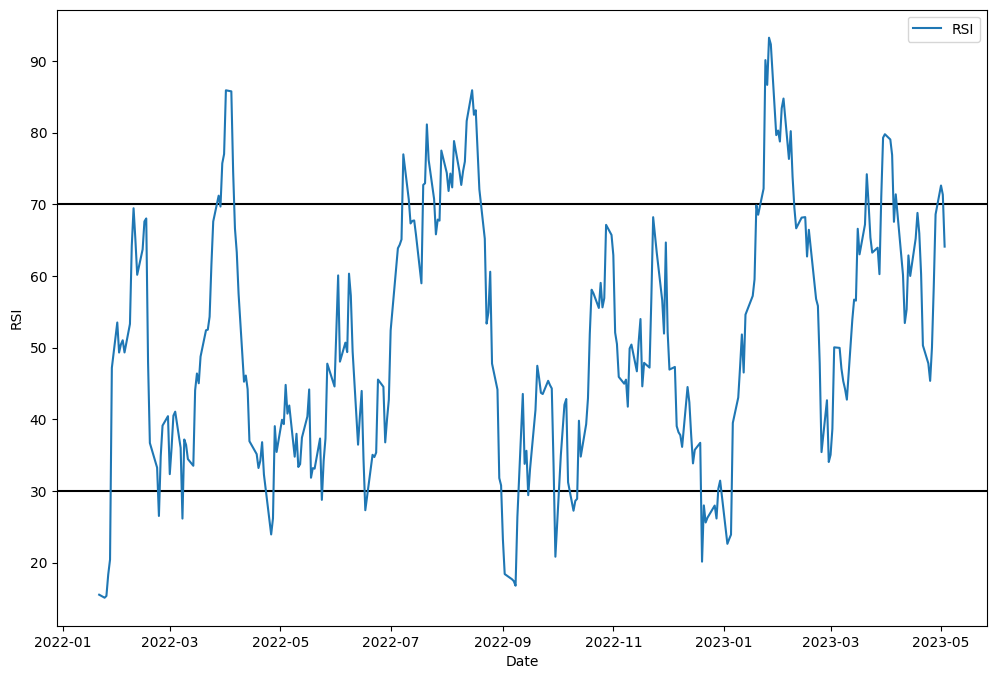

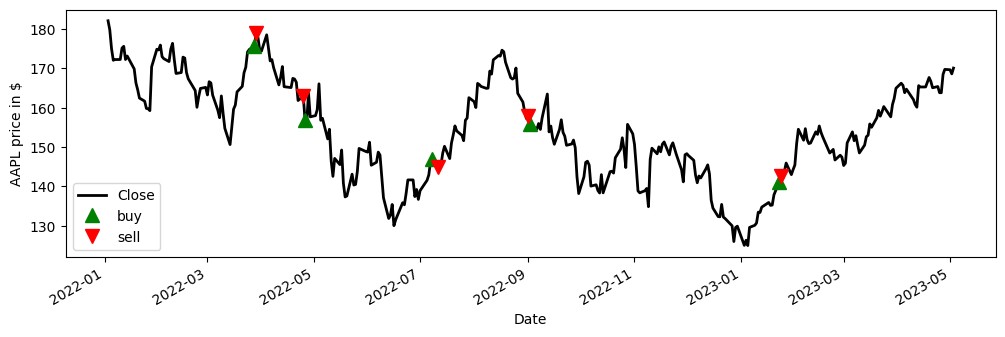

Total portfolio value at the end of the period: 10000.00 $
Total return over the period: 0.00%


In [ ]:
strategy = trading_strategy(ticker,start_date,end_date)

In [ ]:
stock_data = yf.download(ticker, start_date, end_date)
resampled_data = stock_data.resample("1D").last()
resampled_data.dropna(inplace=True)
# Compute the moving averages
resampled_data[f'SMA{str(3)}'] = resampled_data['Close'].rolling(window=3).mean()
resampled_data[f'SMA{str(7)}'] = resampled_data['Close'].rolling(window=7).mean()
print(resampled_data.head(20))

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  177.830002  182.880005  177.710007  182.009995  180.683868   
2022-01-04  182.630005  182.940002  179.119995  179.699997  178.390701   
2022-01-05  179.610001  180.169998  174.639999  174.919998  173.645523   
2022-01-06  172.699997  175.300003  171.639999  172.000000  170.746811   
2022-01-07  172.889999  174.139999  171.029999  172.169998  170.915543   
2022-01-10  169.080002  172.500000  168.169998  172.190002  170.935410   
2022-01-11  172.320007  175.179993  170.820007  175.080002  173.804382   
2022-01-12  176.119995  177.179993  174.820007  175.529999  174.251099   
2022-01-13  175.779999  176.619995  171.789993  172.190002  170.935410   
2022-01-14  171.339996  173.779999  171.089996  173.070007  171.809021   
2022-01-18  171.509995  172.539993  169.410

In [ ]:
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None, doprint=True):
        ''' Logging function fot this strategy'''
        if doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Add the RSI indicator
        self.rsi = bt.indicators.RSI(self.datas[0])

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm), doprint=True)

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Check if we have an open position, and if so check for exits
        if self.position:
            # If RSI is above 70, we sell to exit the long position
            if self.rsi[0] > 70:
                self.log('SELL CREATED by RSI, %.2f' % self.dataclose[0])
                self.order = self.sell()
            # If RSI is below 30, we buy to exit the short position
            elif self.rsi[0] < 30:
                self.log('BUY CREATED by RSI, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if self.position.size == 0:

            # Not yet ... we MIGHT BUY if RSI < 30 and price > SMA
            if self.rsi[0] < 30:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

            # Already in the market ... we MIGHT SELL
            elif self.rsi[0] > 70:
                
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('MA Period: %2d Ending Value %.2f' %
                (self.params.maperiod, self.broker.getvalue()))

In [ ]:
stock_data = yf.download(ticker, start_date, end_date, auto_adjust=True)
# Create a cerebro entity
stock_data = bt.feeds.PandasData(dataname = stock_data)
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Add the Data Feed to Cerebro
cerebro.adddata(stock_data)

# Set our desired cash start
cerebro.broker.setcash(10000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Set the commission
cerebro.broker.setcommission(commission=0.01)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result


[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
2022-01-24, Close, 160.44
2022-01-24, BUY CREATE, 160.44
2022-01-25, BUY EXECUTED, Price: 157.82, Cost: 1578.22, Comm 15.78
2022-01-25, BUY CREATED by RSI, 158.62
2022-01-25, Close, 158.62
2022-01-26, BUY EXECUTED, Price: 162.31, Cost: 1623.09, Comm 16.23
2022-01-26, BUY CREATED by RSI, 158.53
2022-01-26, Close, 158.53
2022-01-27, BUY EXECUTED, Price: 161.27, Cost: 1612.66, Comm 16.13
2022-01-27, BUY CREATED by RSI, 158.06
2022-01-27, Close, 158.06
2022-01-28, BUY EXECUTED, Price: 164.50, Cost: 1645.03, Comm 16.45
2022-01-28, Close, 169.09
2022-01-31, Close, 173.51
2022-02-01, Close, 173.34
2022-02-02, Close, 174.56
2022-02-03, Close, 171.64
2022-02-04, Close, 171.35
2022-02-07, Close, 170.63
2022-02-08, Close, 173.78
2022-02-09, Close, 175.22
2022-02-10, Close, 171.08
2022-02-11, Close, 167.62
2022-02-14, Close, 167.86
2022-02-15, Close, 171.75
2022-02-16, Close, 171.51
2022-02-17, 

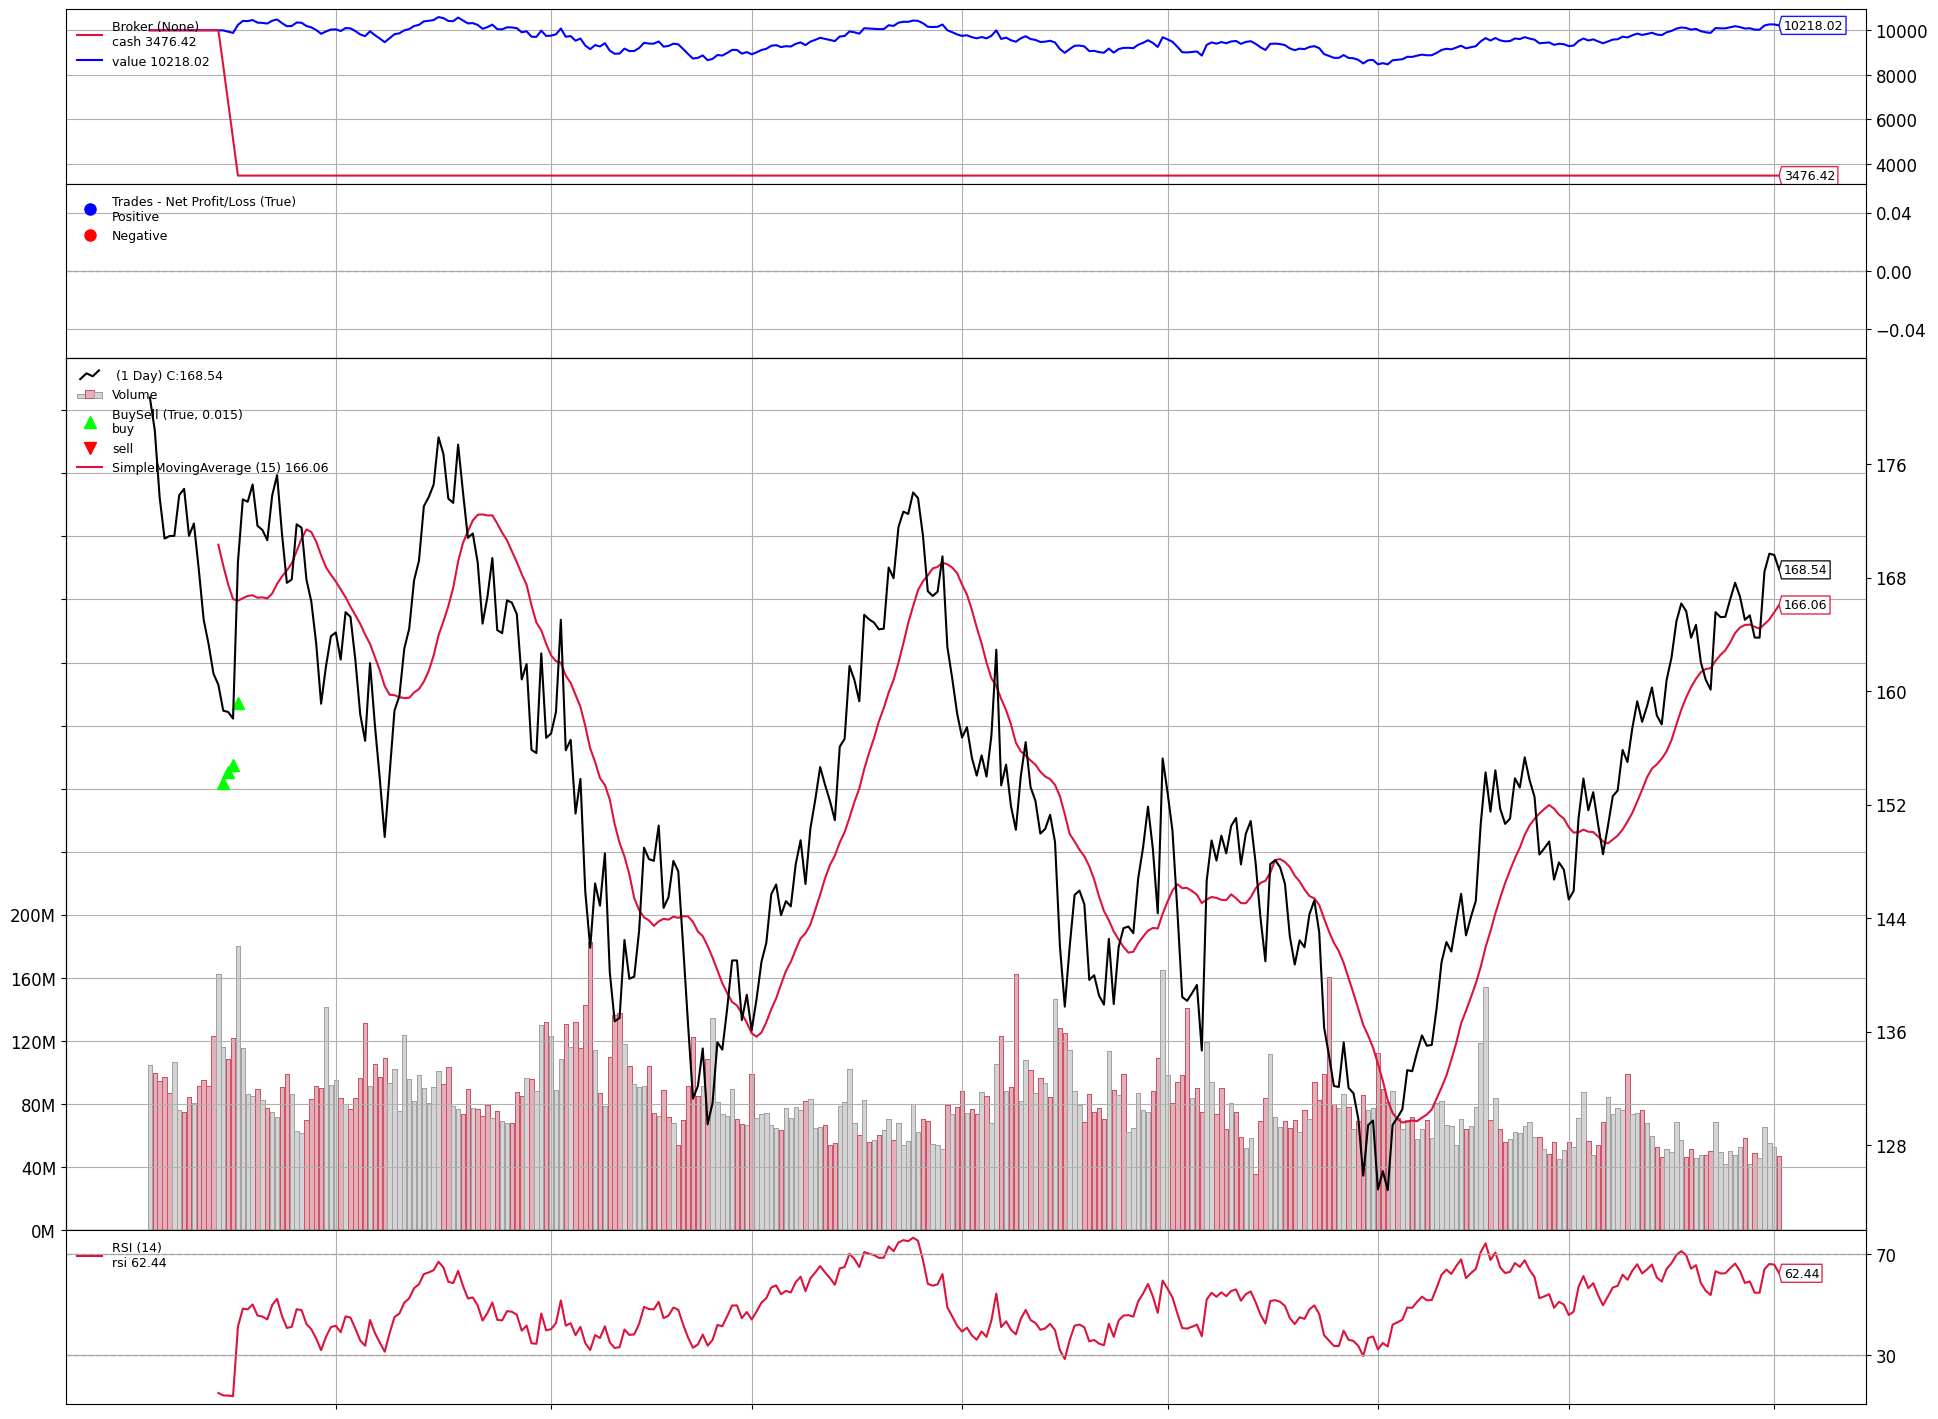

[[<Figure size 2000x1500 with 5 Axes>]]

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams.update({'font.size': 12}) 
cerebro.plot(iplot = False)